In [7]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer

import numpy as np
import tensorflow as tf
import os
import datetime
from collections import OrderedDict as odict 

In [39]:
import keras 
import keras.backend as K

import keras 
import keras.backend as K

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def build_vae(input_dim, latent_dim, middle_arch=(100,100), loss='mse'):


    input_shape = (input_dim,)
    inputs = keras.layers.Input(shape=input_shape, name='encoder_input')
    last = inputs
    first_middle = []
    for i,n in enumerate(middle_arch):
        first_middle.append(keras.layers.Dense(n, activation='relu', name='interm_1.{}'.format(i))(last))
        last = first_middle[i]
    
    z_mean = keras.layers.Dense(latent_dim, name='z_mean')(last)
    z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(last)
    
    z = keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    latent_inputs = keras.layers.Input(shape=(latent_dim,), name='z_sampling')
    last = latent_inputs
    second_middle = []
    for i,n in enumerate(reversed(middle_arch)):
        second_middle.append(keras.layers.Dense(n, activation='relu', name='interm_2.{}'.format(i))(last))
        last = second_middle[i]
    outputs = keras.layers.Dense(input_dim, activation='linear', name='outputs')(last)
    
    decoder = keras.models.Model(latent_inputs, outputs, name='decoder')
    
    output = decoder(encoder(inputs)[2])
    vae = keras.models.Model(inputs, output, name='vae')
    
    reconstruction_loss = getattr(keras.losses, loss)(inputs, output)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    return vae, reconstruction_loss, kl_loss

vae_custom_objects = {
    'sampling': sampling
}

In [95]:
vae, reco_loss, kl_loss = build_vae(19, 4)
custom_objects = vae_custom_objects.copy()

def reco_metric(y_true, y_pred):
    return K.mean(reco_loss)

def kl_metric(y_true, y_pred):
    return K.mean(kl_loss)

vae.compile(loss=[lambda x,y: K.mean(reco_loss) + 0.0001*K.mean(kl_loss)], optimizer='adam', metrics=[reco_metric, kl_metric])



In [97]:
sdata,sjets,sevent,sflavor = utils.load_all_data("data/signal/base_3/*.h5", 'SVJ')
data, jets, event, flavor = utils.load_all_data("data/background/base_3/*.h5", 'background')
norm = data.norm(norm_type='MinMaxScaler')
train_norm, val_norm = norm.train_test_split(0.2)
snorm = data.norm(sdata, norm_type='MinMaxScaler')

history = vae.fit(batch_size=64, x=train_norm.values, y=train_norm.values, validation_data=[val_norm.values, val_norm.values], epochs=10)

Train on 82732 samples, validate on 20684 samples
Epoch 1/10
82732/82732 [==============================] - 5s 61us/step - loss: 0.0024 - reco_metric: 0.0016 - kl_metric: 8.7691 - val_loss: 0.0023 - val_reco_metric: 0.0015 - val_kl_metric: 8.4472
Epoch 2/10
82732/82732 [==============================] - 5s 61us/step - loss: 0.0023 - reco_metric: 0.0014 - kl_metric: 8.3822 - val_loss: 0.0022 - val_reco_metric: 0.0014 - val_kl_metric: 8.2755
Epoch 3/10
82732/82732 [==============================] - 5s 59us/step - loss: 0.0021 - reco_metric: 0.0013 - kl_metric: 8.2694 - val_loss: 0.0022 - val_reco_metric: 0.0013 - val_kl_metric: 8.2484
Epoch 4/10
82732/82732 [==============================] - 5s 60us/step - loss: 0.0021 - reco_metric: 0.0013 - kl_metric: 8.2719 - val_loss: 0.0021 - val_reco_metric: 0.0012 - val_kl_metric: 8.2684
Epoch 5/10
82732/82732 [==============================] - 5s 60us/step - loss: 0.0021 - reco_metric: 0.0012 - kl_metric: 8.3034 - val_loss: 0.0020 - val_reco_metr

In [98]:


recon = utils.data_table(vae.predict(norm.values), name='qcd pred', headers=data.columns)
srecon = utils.data_table(vae.predict(snorm.values), name='signal pred', headers=data.columns)


In [109]:
errs, recon = utils.get_recon_errors(data_list=[norm, snorm], autoencoder=vae)

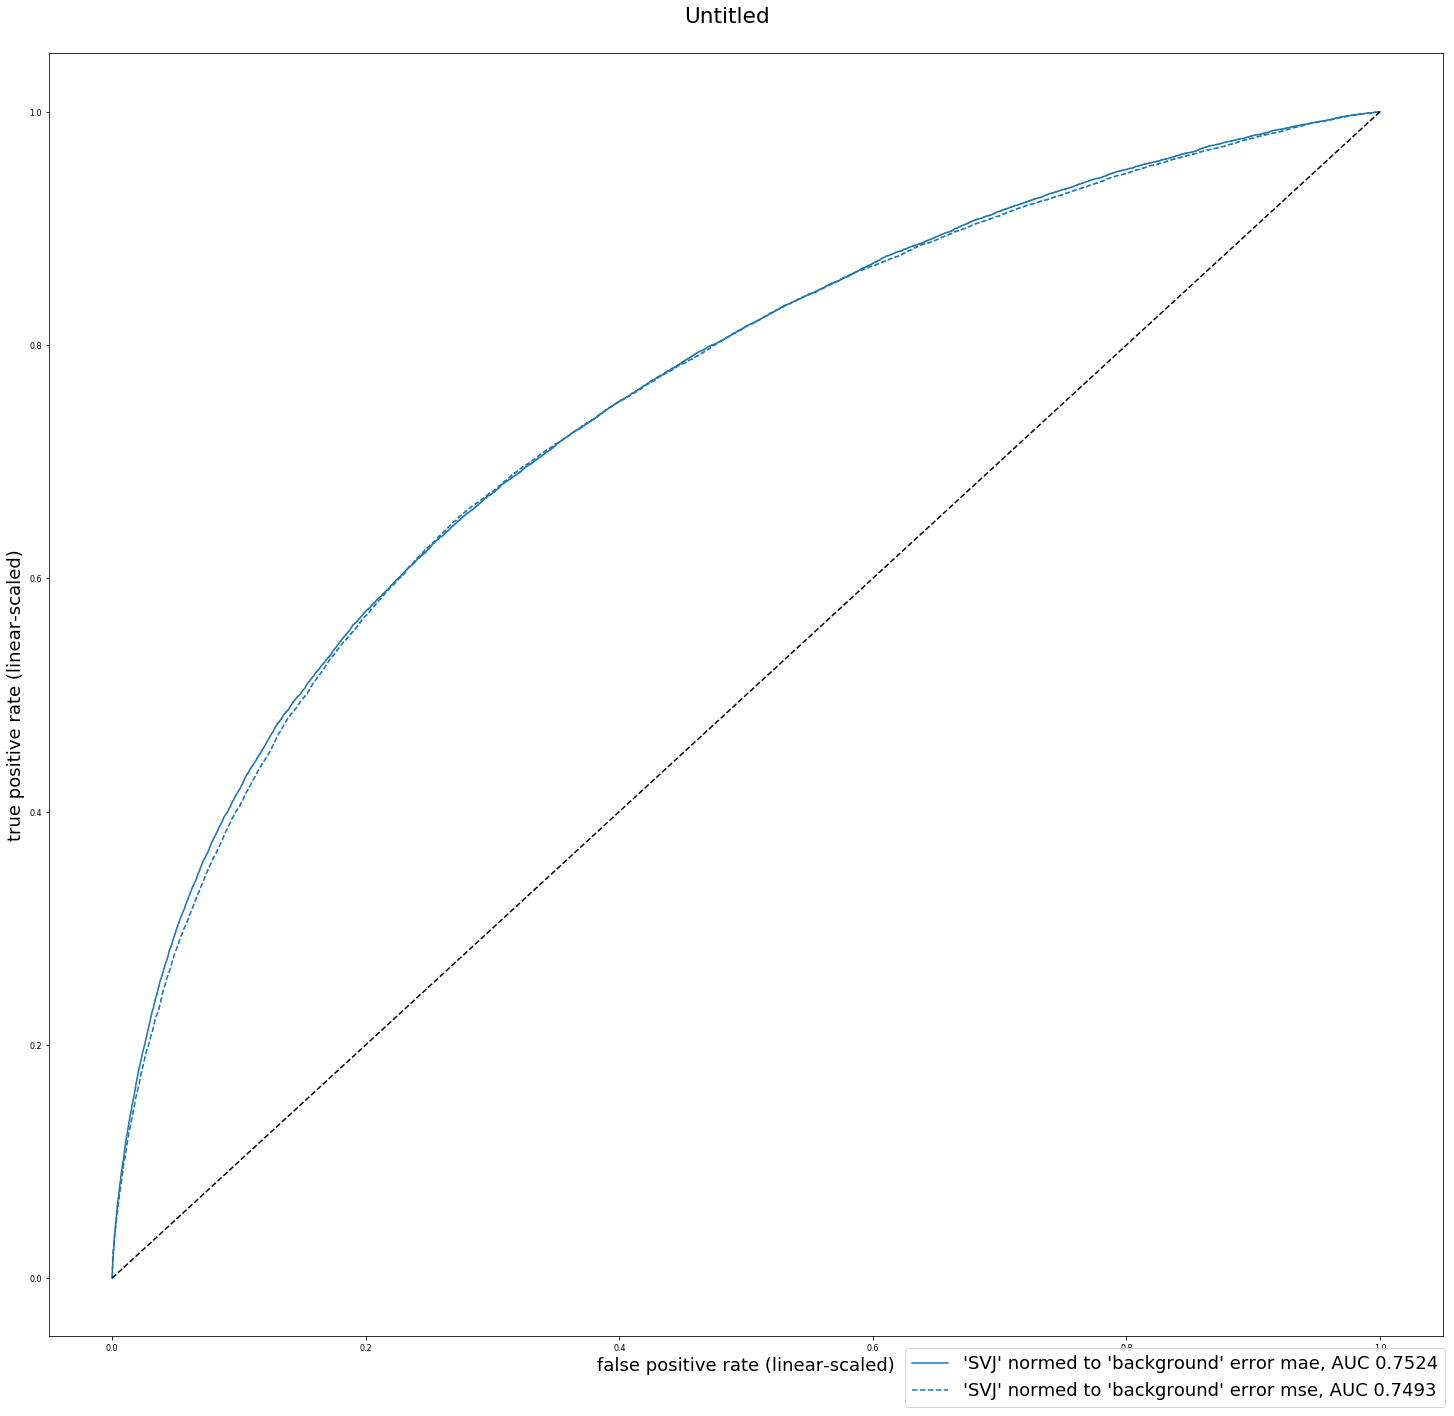

In [119]:
utils.roc_auc_plot(data_errs=errs[0], signal_errs=errs[1], metrics=['mae', 'mse'])

data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'background' pred", "'SVJ' normed to 'background' pred", "'background' normed to 'background'", "'SVJ' normed to 'background'"]


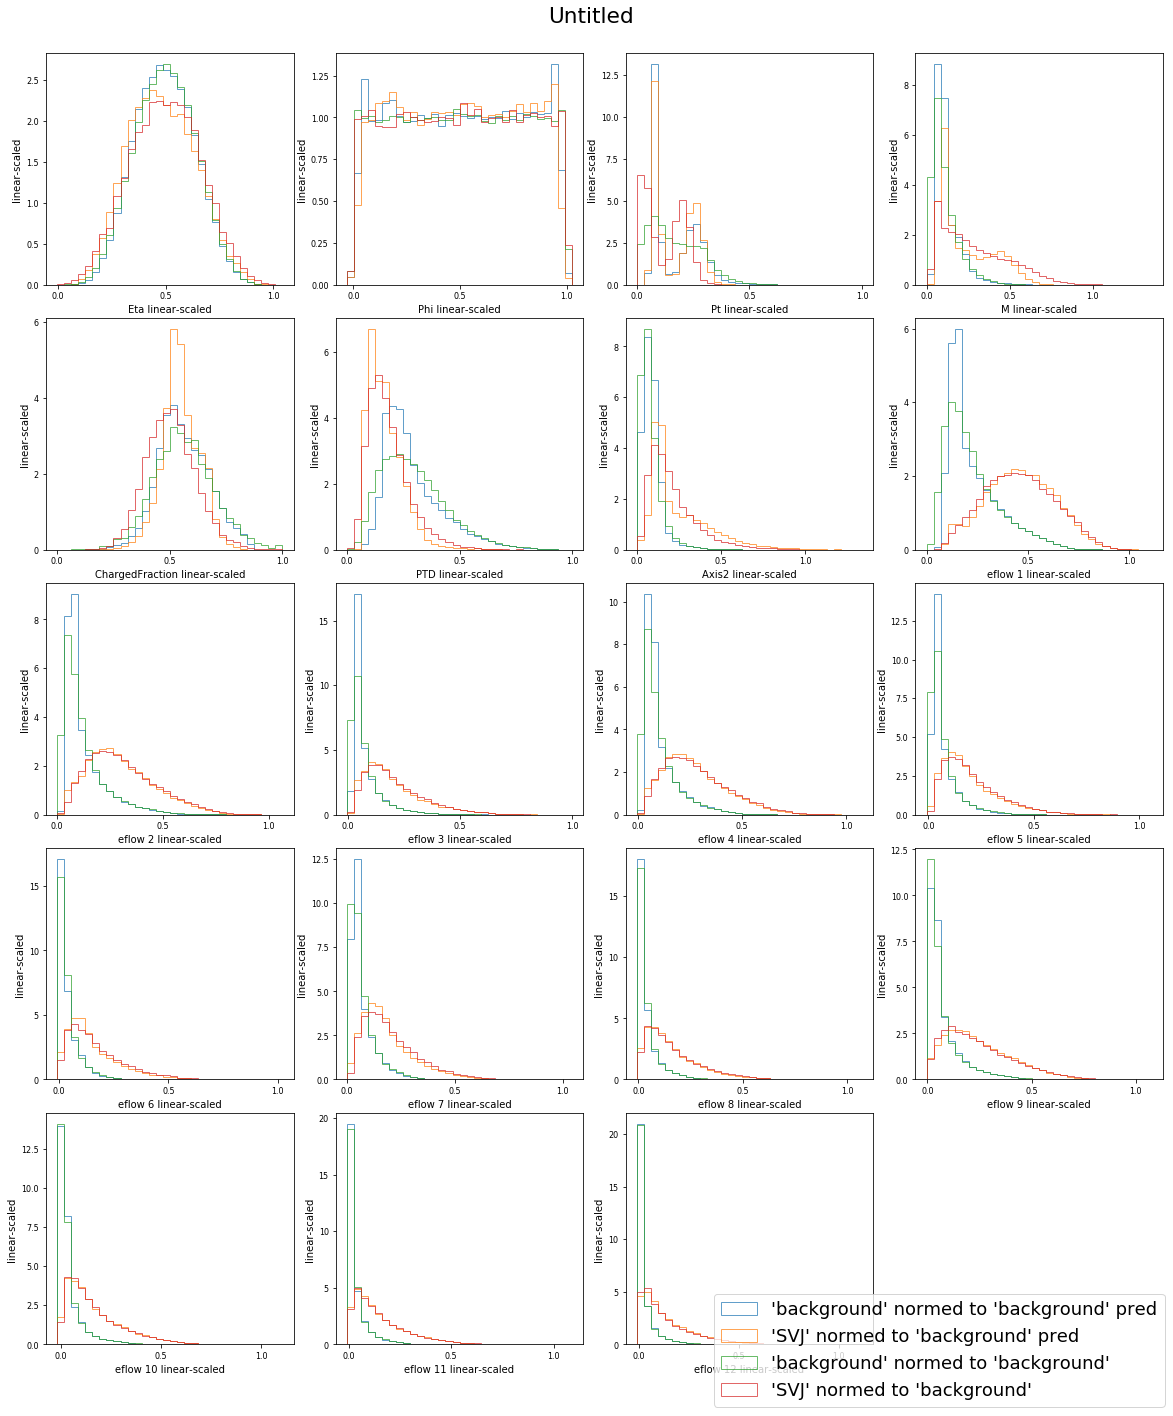

In [114]:
recon[0].plot(recon[1:] + [norm, snorm], normed=1)

In [112]:
recon.plot([norm, srecon, snorm], normed=1)

AttributeError: 'list' object has no attribute 'plot'

data_table :: plotting distrubution(s) for table(s) ['pred', 'true']


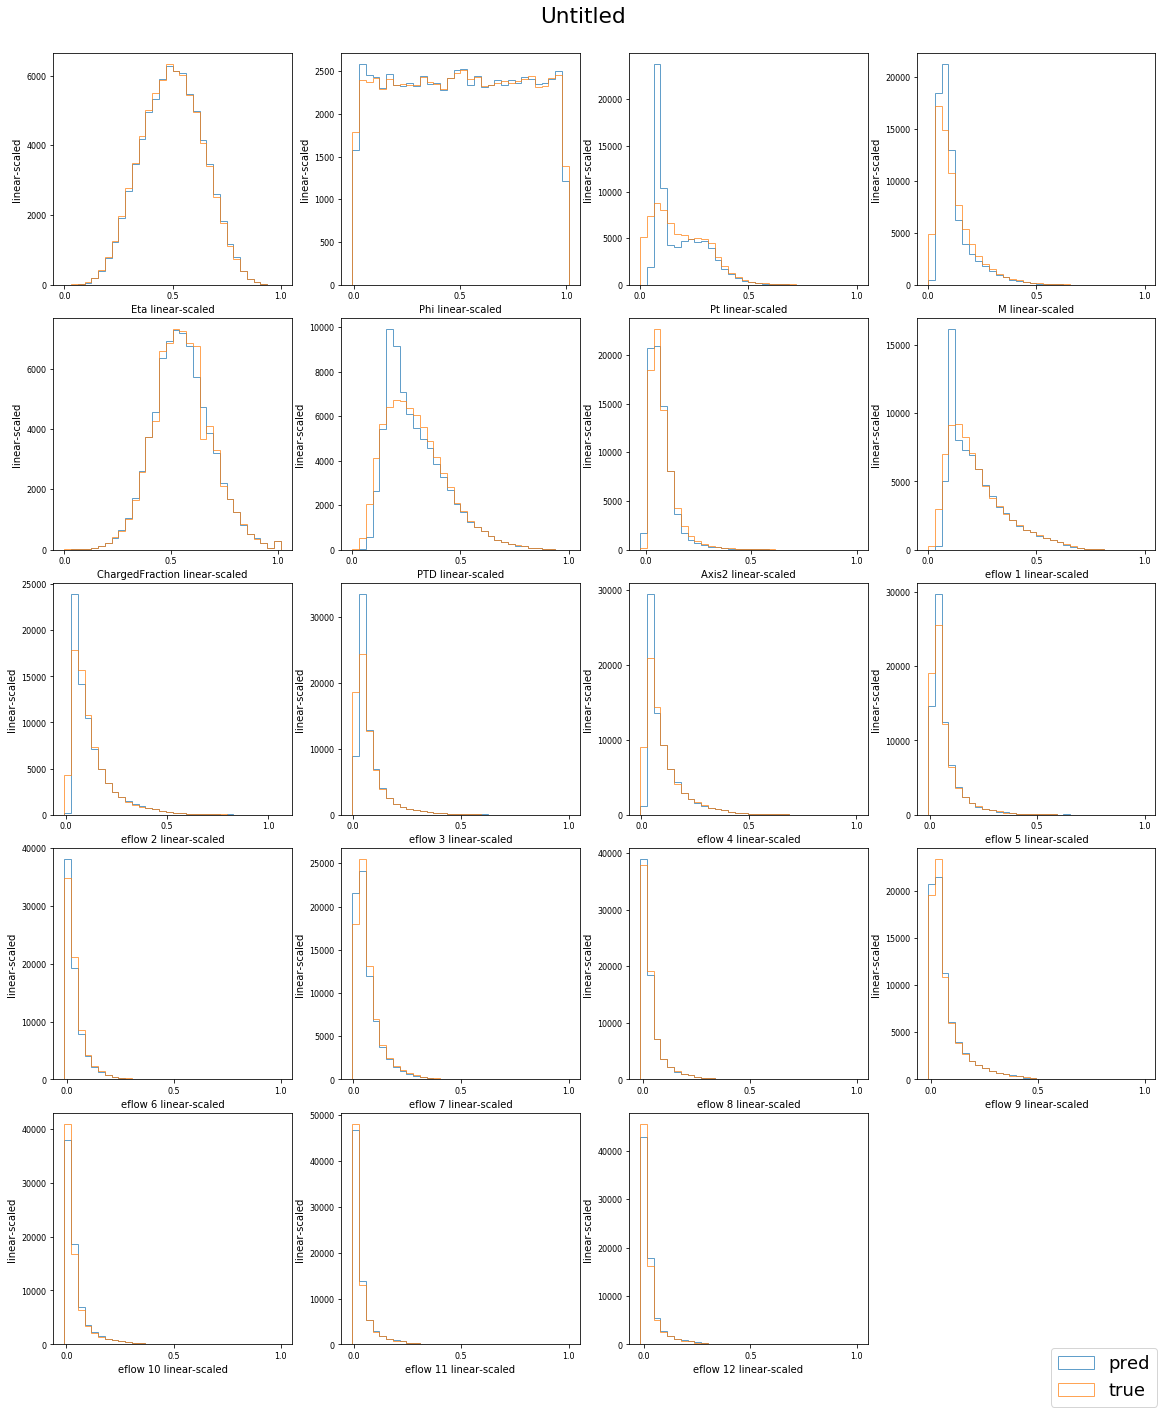

In [75]:

recon.plot(true)

In [52]:
def vae_train(
    signal_path,
    qcd_path,
    target_dim,
    hlf=True,
    eflow=True,
    version=None,
    seed=None,
    test_split=0.15, 
    val_split=0.15,
    norm_args={
        "norm_type": "MinMaxScaler"
    },
    train_me=True,
    batch_size=64,
    loss='mse',
    optimizer='adam',
    epochs=100,
    learning_rate=0.0005,
    interm_architecture=(30,30),
    output_data_path=None,
    verbose=1, 
    hlf_to_drop=['Energy', 'Flavor'],
):

    """Training function for basic autoencoder (inputs == outputs). 
    Will create and save a summary file for this training run, with relevant
    training details etc.

    Not super flexible, but gives a good idea of how good your standard AE is.
    """

    if seed is None:
        seed = np.random.randint(0, 99999999)

    # set random seed
    utils.set_random_seed(seed)

    if output_data_path is None:
        output_data_path = os.path.join(utils.get_repo_info()['head'], "autoencode/data/training_runs")

    # get all our data
    (signal,
     signal_jets,
     signal_event,
     signal_flavor) = utils.load_all_data(
        signal_path,
        "signal", include_hlf=hlf, include_eflow=eflow,
        hlf_to_drop=hlf_to_drop,
    )

    (qcd,
     qcd_jets,
     qcd_event,
     qcd_flavor) = utils.load_all_data(
        qcd_path, 
        "qcd background", include_hlf=hlf, include_eflow=eflow,
        hlf_to_drop=hlf_to_drop,
    )

    if eflow:
        qcd_eflow = len(filter(lambda x: "eflow" in x, qcd.columns))
        signal_eflow = len(filter(lambda x: "eflow" in x, signal.columns))

        assert qcd_eflow == signal_eflow, 'signal and qcd eflow basis must be the same!!'
        eflow_base = eflow_base_lookup[qcd_eflow]
    else:
        eflow_base = 0

    filename = "{}{}{}_".format('hlf_' if hlf else '', 'eflow{}_'.format(eflow_base) if eflow else '', target_dim)
    
    if version is None:
        existing_ids = map(lambda x: int(os.path.basename(x).rstrip('.summary').split('_')[-1].lstrip('v')), utils.summary_match(filename + "v*", 0))
        assert len(existing_ids) == len(set(existing_ids)), "no duplicate ids"
        id_set = set(existing_ids)
        this_num = 0
        while this_num in id_set:
            this_num += 1
        
        version = this_num

    filename += "v{}".format(version)

    assert len(utils.summary_match(filename, 0)) == 0, "filename '{}' exists already! Change version id, or leave blank.".format(filename)

    filepath = os.path.join(output_data_path, filename)
    input_dim = len(signal.columns)
    
    custom_objects = vae_custom_objects

    data_args = {
        'target_dim': target_dim,
        'input_dim': input_dim,
        'test_split': test_split,
        'val_split': val_split,
        'hlf': hlf, 
        'eflow': eflow,
        'eflow_base': eflow_base,
        'seed': seed,
        'filename': filename,
        'filepath': filepath,
        'qcd_path': qcd_path,
        'signal_path': signal_path,
        'arch': (input_dim,) + interm_architecture + (target_dim,) + tuple(reversed(interm_architecture)) + (input_dim,),
        'hlf_to_drop': tuple(hlf_to_drop),
        'ae_type': 'vae'
    }

    all_train, test = qcd.split_by_event(test_fraction=test_split, random_state=seed, n_skip=len(qcd_jets))
    train, val = all_train.train_test_split(val_split, seed)

    train_norm = train.norm(out_name="qcd train norm", **norm_args)
    val_norm = train.norm(val, out_name="qcd val norm", **norm_args)
    
    test_norm = test.norm(out_name="qcd test norm", **norm_args)
    signal_norm = test.norm(signal, out_name="signal norm", **norm_args)

    train.name = "qcd training data"
    test.name = "qcd test data"
    val.name = "qcd validation data"

    instance = trainer.trainer(filepath, verbose=verbose)
    
    loss_reco = loss
    ae, loss, kl_loss = build_vae(input_dim=input_dim, latent_dim=target_dim, middle_arch=interm_architecture, loss=loss_reco)

    vae, reco_loss, kl_loss = build_vae(19, 2)

    def reco_metric(y_true, y_pred):
        return K.mean(reco_loss)

    def kl_metric(y_true, y_pred):
        return K.mean(kl_loss)
    
    def vae_loss(y_true, y_pred):
        return K.mean(reco_loss + kl_loss)

    custom_objects = vae_custom_objects.copy()
    custom_objects['reco_metric'] = reco_metric
    custom_objects['kl_metric'] = kl_metric
    custom_objects['vae_loss'] = vae_loss

    vae.compile(loss=[vae_loss], optimizer='adam', metrics={'reco_metric': reco_metric, 'kl_metric': kl_metric})
    
    start_time = str(datetime.datetime.now())
    
    metrics = [loss_reco, lambda: kl_loss]

    train_args = {
        'batch_size': batch_size, 
        'optimizer': optimizer,
        'epochs': epochs,
        'learning_rate': learning_rate,
        
    }

    if verbose:
        print "TRAINING WITH PARAMS >>>"
        for arg in train_args:
            print arg, ":", train_args[arg]
 

    return train_norm.data, val_norm.data
    if train_me:
        ae = instance.train(
            x_train=train_norm.data,
            x_test=val_norm.data,
            y_train=train_norm.data,
            y_test=val_norm.data,
            model=ae,
            force=True,
            use_callbacks=True,
            custom_objects=custom_objects, 
            verbose=int(verbose),
            metrics=metrics,
            **train_args
        )
    else:
        ae = instance.load_model(custom_objects=custom_objects)
        
    train_args['loss'] = loss_reco

    end_time = str(datetime.datetime.now())

    [data_err, signal_err], [data_recon, signal_recon] = utils.get_recon_errors([test_norm, signal_norm], ae)
    roc_dict = utils.roc_auc_dict(data_err, signal_err, metrics=['mae', 'mse']).values()[0]
    result_args = dict([(r + '_auc', roc_dict[r]['auc']) for r in roc_dict])

    vid = utils.summary_vid()
    
    time_args = {'start_time': start_time, 'end_time': end_time, 'VID': vid}
    utils.dump_summary_json(result_args, train_args, data_args, norm_args, time_args)

    # roc as figure of merit
    return max(result_args.values())


from autoencodeSVJ.evaluate import eflow_base_lookup
train_norm, val_norm = vae_train(qcd_path="data/background/base_3/*.h5", signal_path="data/signal/base_3/*.h5", target_dim=8, epochs=5)

TRAINING WITH PARAMS >>>
epochs : 5
learning_rate : 0.0005
optimizer : adam
batch_size : 64


In [30]:
import keras
keras.losses.ms

In [38]:
def get_vae_loss(loss, vae):
    z_mean = vae.layers[1].get_layer('z_mean')
    z_log_var = vae.layers[1].get_layer('z_mean')
    
    inputs = vae.layers[0]
    
    print vae.layers[2].summary()
    reconstruction_loss = getattr(keras.losses, loss)(inputs, outputs)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    return vae_loss
        
get_vae_loss('mse', vae)

ValueError: Layer encoder was called with an input that isn't a symbolic tensor. Received type: <class 'keras.engine.topology.InputLayer'>. Full input: [<keras.engine.topology.InputLayer object at 0x7f6f40675650>]. All inputs to the layer should be tensors.